### Visualizing the distribution of the observations

### Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBBBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib


/Users/sumangunnala/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12376
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|    10|[80 49 40 4C E0 D...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     1|[30 54 40 4C A0 D...|1950.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 C9 40 4C 40 5...|1951.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[E0 D4 30 D5 F0 D...|1952.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 4D 80 4D A0 5...|1953.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Select data for a particular station and measurement type

In [219]:
sqlContext.registerDataFrameAsTable(df,'weather')

# This station ID has to match one of the station ID that you have from above list
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMIN','USC00102260')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
rows1=df1.rdd.map(lambda row:row['year']).collect()
T=np.vstack(rows)
T1=np.vstack(rows1)
#T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMIN' and station='USC00102260'
45 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1797.4|  43.465|-113.5581|       TMIN|USC00102260|     2|[40 D6 38 D9 F0 D...|1959.0|SBSSBBBS|
|   1797.4|  43.465|-113.5581|       TMIN|USC00102260|     7|[60 D9 F0 DA 40 D...|1960.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(45, 365)

In [82]:
print T.shape
print T1.shape
tt1 = np.concatenate((T1,T),axis = 1)
tt1.shape
tt1_df = pd.DataFrame(tt1)
tt1_df.set_index()

(77, 365)
(77, 1)


TypeError: set_index() takes at least 2 arguments (1 given)

### Script for plotting yearly plots

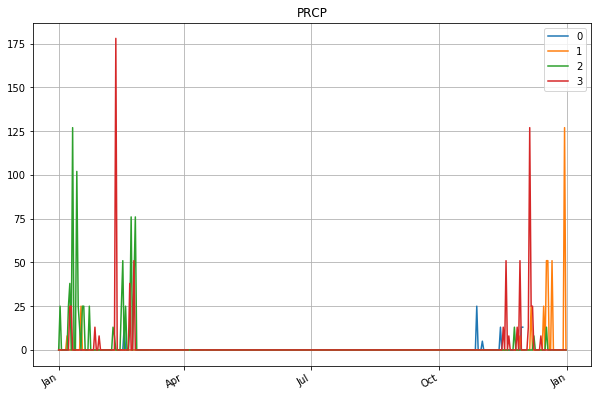

In [51]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[55:59,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [232]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

In [83]:
#STAT_Descriptions

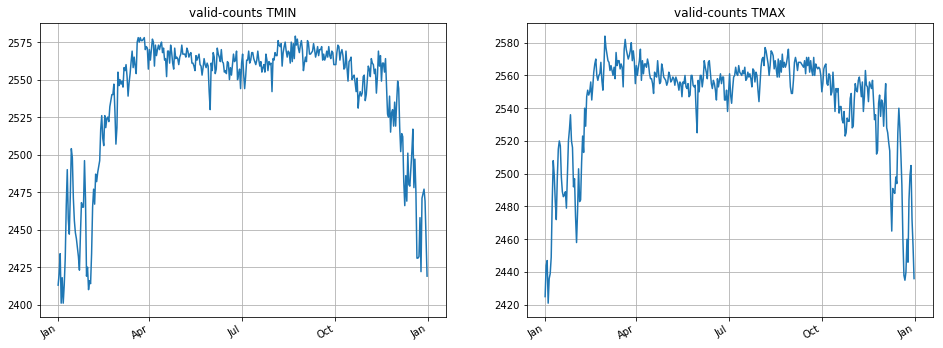

In [26]:
plot_pair(['TMIN','TMAX'],plot_valid)

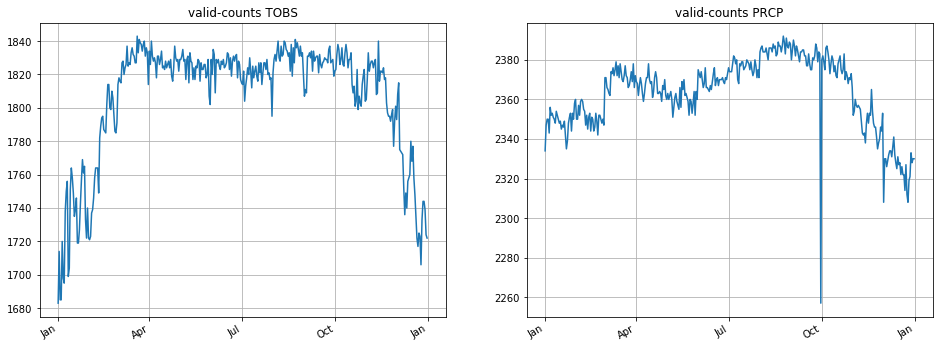

In [27]:
plot_pair(['TOBS','PRCP'],plot_valid)

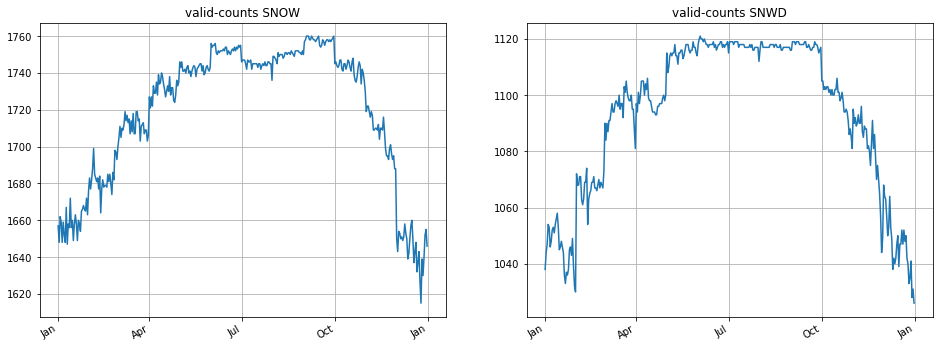

In [28]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [233]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']*1.0/10*(9.0/5)+32
    std=np.sqrt(STAT[m]['Var'])*1.0/10*(9.0/5)+32
    #graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    graphs=np.vstack([mean]).transpose() # this is just to check on mean
    #YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    YP.plot(graphs,fig,axis,title='Mean   '+m)
    return mean, std

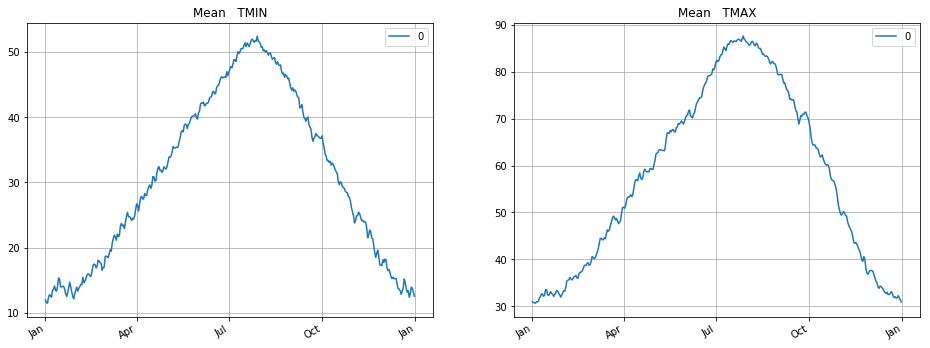

In [236]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

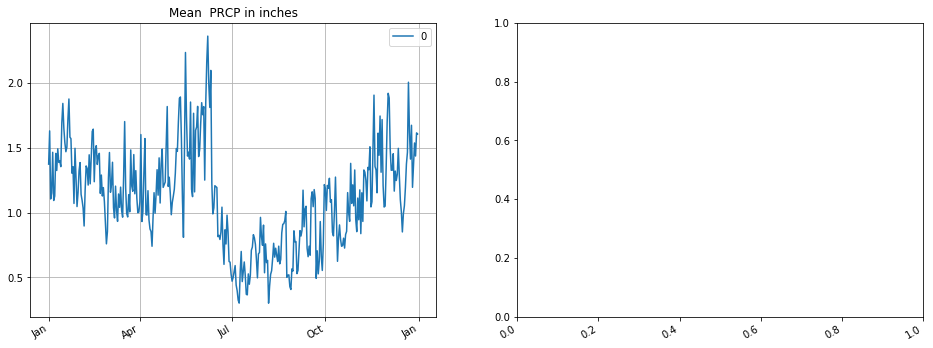

In [237]:
plot_pair([ 'PRCP'],plot_mean_std_snow)
#plot_pair(['TOBS'],plot_mean_std)

In [222]:
def plot_mean_std_snow(m,fig,axis):
    mean=STAT[m]['Mean']*.04 *3 # mm to inches
    std=np.sqrt(STAT[m]['Var'])*.04 *3
    graphs=np.vstack([mean]).transpose()
    #graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean  '+m+' in inches')
    #YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

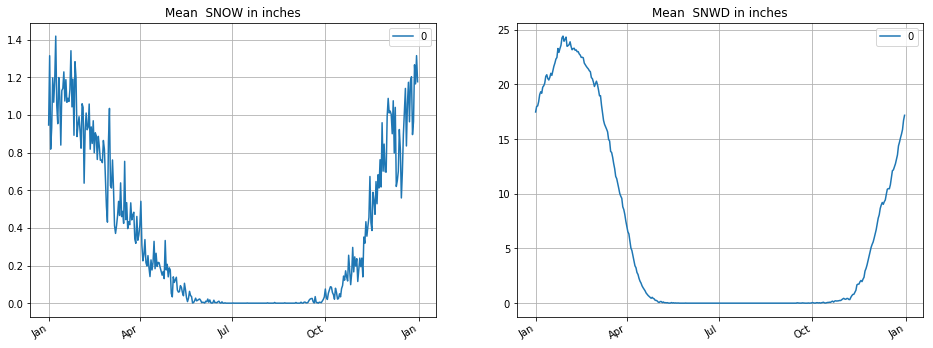

In [223]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std_snow)

In [135]:
t100 = STAT[m]

EV=STAT[m]['eigvec']
EV.shape
# EV is eigen vectors

(365, 365)

In [140]:
t100.keys()
STAT_Descriptions

[('SortedVals',
  'Sample of values',
  'vector whose length varies between measurements'),
 ('UnDef',
  'sample of number of undefs per row',
  'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))]

### plotting top 3 eigenvectors

In [243]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']*(-1)
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

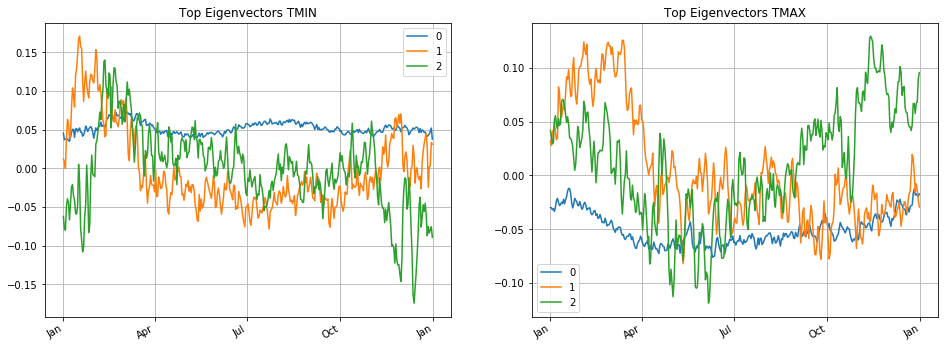

In [241]:
plot_pair(['TMIN','TMAX'],plot_eigen)

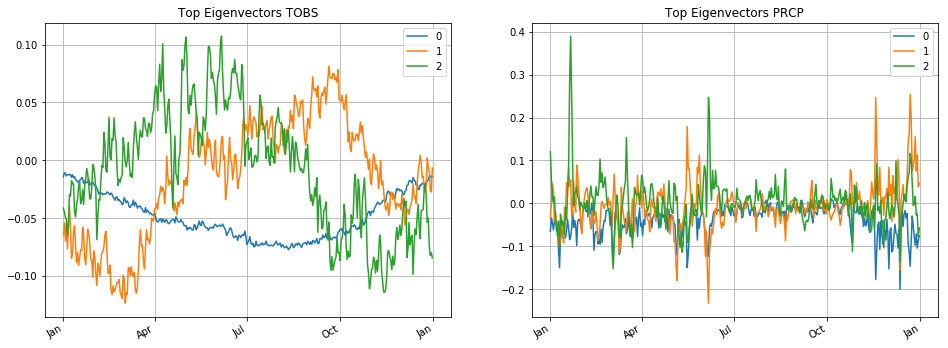

In [242]:
plot_pair(['TOBS','PRCP'],plot_eigen)

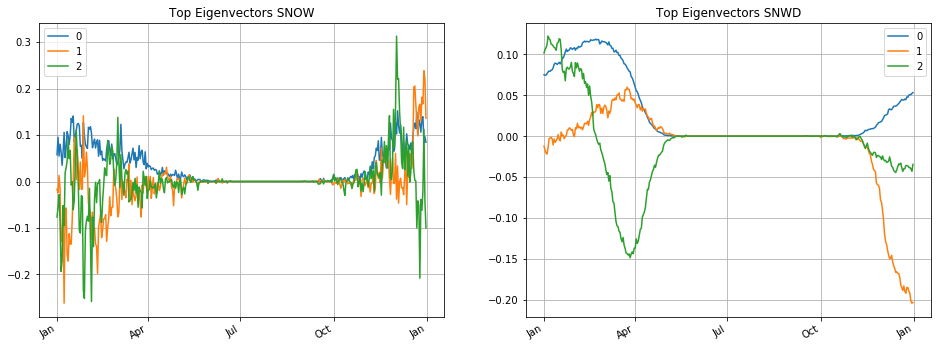

In [244]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

In [151]:
EVal=STAT[m]['eigval']
EVal[:4]

array([ 183827.8757325 ,   44824.63338762,   34046.98978601,
         30617.93225869])

### Script for plotting percentage of variance explained

In [162]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=3
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

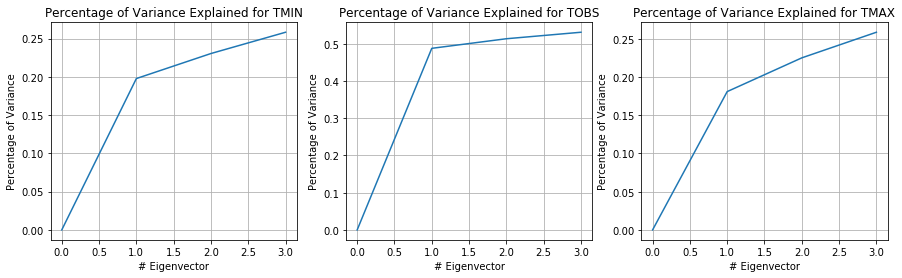

In [163]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

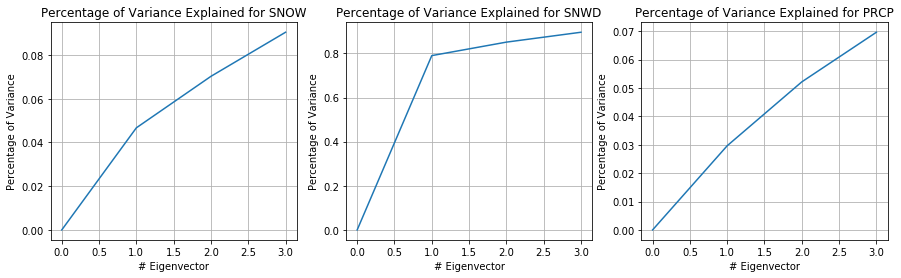

In [164]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()